
# **Trabajo Práctico 1 : Reservas de Hotel**
### *Checkpoint 2*
###Grupo 22: JARVIS
+ 107666	CELANO MINIG, NICOLÁS FRANCO
+ 108642	RANDO, JULIAN AGUSTIN
+ 106421	GOMEZ, ALEJO

Primero realizamos todos los importes necesarios.

In [ ]:
!pip install 'dtreeviz'
import pandas as pd
import numpy as np
from IPython.display import display
import datetime
import dtreeviz.trees as dtreeviz
import graphviz
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, classification_report
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
colors = sns.color_palette(n_colors=15)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Traemos los dos dataset que usaremos.

In [ ]:
hotels_train_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/df_hotel_v3.csv"
hotels_test_url = "https://raw.githubusercontent.com/agomezalejo/7506R-1C2023-GRUPO22/main/hotels_test.csv"
df_original = pd.read_csv(hotels_train_url)
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel_test_con_is_canceled = df_hotel_test.copy()
df_hotel = df_original.copy()

Como anteriormente en el dataset de train realizamos modificaciones en los datos, debemos replicarlas todas al dataset de test.

In [ ]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

Ahora, dividimos el dataframe en caracteristicas y etiquetas, y realizamos dummies para poder utilizar el arbol de decisión.

In [ ]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

X = pd.get_dummies(X, columns=['hotel','arrival_date_year', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type',
                               'deposit_type', 'agent', 'company', 'customer_type'], drop_first=True)

df_hotel_test = pd.get_dummies(df_hotel_test, columns=['hotel','arrival_date_year', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type',
                               'deposit_type', 'agent', 'company', 'customer_type'], drop_first=True)

Además, todas las columnas que se crearon en df_hotel deben existir en df_hotel_test, por lo que completaremos con las faltantes

In [ ]:
columns_X = set(X.columns)
columns_test = set(df_hotel_test.columns)

missing_columns = list(columns_X - columns_test)
for column in missing_columns:
    df_hotel_test[column] = 0

df_hotel_test = df_hotel_test[X.columns]

<ipython-input-141-6751b57bc7ba>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<ipython-input-141-6751b57bc7ba>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<ipython-input-141-6751b57bc7ba>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<ipython-input-141-6751b57bc7ba>:6: PerformanceWarning: DataF

Ahora, antes de seguir observemos el tamaño de nuestros dataframes

In [ ]:
print("Cantidad de columnas de test:", df_hotel_test.shape[1])
print("Cantidad de columnas de train:", X.shape[1])

Cantidad de columnas de test: 780
Cantidad de columnas de train: 780


Podemos ver que es una cantidad muy elevada, por lo que más adelante tomaremos alguna decisión con respecto a ello, pero primero intentaremos armar un arbol de decisión para observar cuales son las características más importantes a tener en cuenta.

In [ ]:
def arbol_decision_random_search(param_dist, cv, n_iter):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = DecisionTreeClassifier()

  random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring='f1', cv=cv, n_iter=n_iter, random_state=42)
  random_search.fit(X_train, y_train) 

  best_params = random_search.best_params_
  best_model = DecisionTreeClassifier(**best_params)

  best_model.fit(X_train, y_train)
  y_pred = best_model.predict(X_test)

  f1 = f1_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  print("Mejores hiperparámetros encontrados:", best_params)
  print("F1_score en el conjunto de prueba:", f1)
  print("Accuracy en el conjunto de prueba:", accuracy)
  print("Precision en el conjunto de prueba:", precision)
  
  return best_model

In [ ]:
def caracteristicas_importantes(best_model, top):
  importancias = best_model.feature_importances_
  importancias_df = pd.DataFrame({'caracteristica': X.columns, 'importancia': importancias})
  importancias_df = importancias_df.sort_values('importancia', ascending=False)
  print(importancias_df.head(top))

Este es un primer acercamiento, por lo que los hiperparametros usados se reveeran más adelante.

In [ ]:
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [15, 20],
    'min_samples_split': [10, 15], 
    'min_samples_leaf': [2, 6],
    'max_leaf_nodes': [50, 100],
    'ccp_alpha': [0, 0.00005]  
}

best_model = arbol_decision_random_search(param_dist, 5, 10)

Mejores hiperparámetros encontrados: {'min_samples_split': 15, 'min_samples_leaf': 2, 'max_leaf_nodes': 100, 'max_depth': 20, 'criterion': 'entropy', 'ccp_alpha': 5e-05}
F1_score en el conjunto de prueba: 0.8420018019493817
Accuracy en el conjunto de prueba: 0.8431452268661571
Precision en el conjunto de prueba: 0.8438680019701198


In [ ]:
caracteristicas_importantes(best_model, 45)

                     caracteristica  importancia
208         deposit_type_Non Refund     0.331278
186        market_segment_Online TA     0.138158
0                         lead_time     0.077354
13      required_car_parking_spaces     0.070105
144                     country_PRT     0.059703
14        total_of_special_requests     0.058410
301                     agent_240.0     0.035297
8            previous_cancellations     0.033374
778         customer_type_Transient     0.020040
496                       agent_9.0     0.018874
183           market_segment_Direct     0.018145
16           arrival_date_year_2016     0.017206
479                       agent_7.0     0.016131
17           arrival_date_year_2017     0.012577
9    previous_bookings_not_canceled     0.012434
10                  booking_changes     0.010949
259                      agent_17.0     0.010537
302                     agent_241.0     0.008450
12                              adr     0.007423
779   customer_type_

Observemos que hay atributos que no aparecen, como por ejemplo children, babies, hotel. Vamos a eliminar algunas columnas para reducir el tamaño del dataset.

Primero volvemos a cargar los dataset y realizar los mismos cambios anteriores.

In [ ]:
df_hotel_test = pd.read_csv(hotels_test_url)
df_hotel = df_original.copy()

In [ ]:
df_hotel_test = df_hotel_test.drop('id', axis=1)
df_hotel_test = df_hotel_test.drop('arrival_date_week_number', axis=1)
df_hotel_test = df_hotel_test.drop('reservation_status_date', axis=1)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)
df_hotel['is_repeated_guest'] = df_hotel['is_repeated_guest'].astype(int)
df_hotel['is_canceled'] = df_hotel['is_canceled'].astype(int)
df_hotel_test['company'] = df_hotel_test['company'].fillna('not company')
df_hotel_test['company'] = df_hotel_test['company'].astype(str)
df_hotel_test['agent'] = df_hotel_test['agent'].fillna('not agent')
df_hotel_test['agent'] = df_hotel_test['agent'].astype(str)

Ahora empezamos con las nuevas modificaciones, eliminaremos babies, childre, assigned_room_type y reserver_room_type.

In [ ]:
df_hotel_test = df_hotel_test.drop('babies', axis=1)
df_hotel = df_hotel.drop('babies', axis=1)

df_hotel_test = df_hotel_test.drop('children', axis=1)
df_hotel = df_hotel.drop('children', axis=1)

Además, vamos a cambiar en country, agent, y company. Pondremos una columna nueva con la probabilidad de que sea cancelado y eliminaremos a country, agent y company; ya que estos 3 cuando hacíamos dummies nos traía una gran cantidad de columnas nuevas.

In [ ]:
def cambiar_columna_por_probabilidad_is_canceled(columna):
  global df_hotel_test, df_hotel
  probabilidades = df_hotel.groupby(columna)['is_canceled'].mean()
  nueva_columna = columna+'_prob_is_canceled'

  df_hotel[nueva_columna] = 0
  df_hotel[nueva_columna] = df_hotel[columna].map(probabilidades)

  df_hotel_test[nueva_columna] = 0
  df_hotel_test[nueva_columna] = df_hotel_test[columna].map(probabilidades)

  mediana = df_hotel_test[nueva_columna].median()
  df_hotel_test[nueva_columna].fillna(mediana, inplace=True)

  df_hotel_test = df_hotel_test.drop(columna, axis=1)
  df_hotel = df_hotel.drop(columna, axis=1)

In [ ]:
cambiar_columna_por_probabilidad_is_canceled('country')
cambiar_columna_por_probabilidad_is_canceled('agent')
cambiar_columna_por_probabilidad_is_canceled('company')

Volvemos a dividir el dataframe en caracteristicas y etiquetas, y realizamos dummies para poder utilizar el arbol de decisión.

In [ ]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

columns = ['hotel','arrival_date_year', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel','deposit_type', 'customer_type', 'assigned_room_type', 'reserved_room_type']

X = pd.get_dummies(X, columns=columns, drop_first=True)

df_hotel_test = pd.get_dummies(df_hotel_test, columns=columns, drop_first=True)

X.head(5)

,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,country_prob_is_canceled,agent_prob_is_canceled,company_prob_is_canceled,hotel_Resort Hotel,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L
0,49,5,1,2,1,0,0,0,0,0,115.5,0,1,0.340864,0.547109,0.513572,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,4,31,0,1,2,0,0,0,0,0,42.0,1,0,0.689052,0.359418,0.513572,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,25,13,0,1,2,0,0,0,0,0,229.0,0,2,0.363744,0.547109,0.513572,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,26,12,2,5,2,0,0,0,0,0,75.0,0,0,0.689052,0.803279,0.513572,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,104,19,2,5,2,0,0,0,0,0,75.0,0,1,0.278890,0.798780,0.513572,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Además, todas las columnas que se crearon en df_hotel deben existir en df_hotel_test, por lo que completaremos con las faltantes

In [ ]:
columns_X = set(X.columns)
columns_test = set(df_hotel_test.columns)

missing_columns = list(columns_X - columns_test)
for column in missing_columns:
    df_hotel_test[column] = 0

df_hotel_test = df_hotel_test[X.columns]

Veamos que ahora la cantidad de columnas fue reducida.

In [ ]:
print("Cantidad de columnas de test:", df_hotel_test.shape[1])
print("Cantidad de columnas de train:", X.shape[1])

Cantidad de columnas de test: 66
Cantidad de columnas de train: 66


Ahora probaremos con una amplia variedad de hiperparametros, para observar cual es el mejor y luego seguir ajustandolos.

Utilizaremos cross-validation de 10 folds para buscar los mejores parámetros mediante una búsqueda aleatoria. La elección de 10 folds es una opción común y se considera un buen balance.

Para la búsqueda de parámetros, se eligió la métrica F1_score como medida adecuada para evaluar el rendimiento del modelo. Es una métrica utilizada ya que tiene en cuenta tanto la precisión como el recall del modelo, lo que proporciona una medida más equilibrada del rendimiento en comparación con otras métricas como la precisión o la exactitud.

In [ ]:
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [40, 50, 60, 70],
    'min_samples_split': [10, 12, 14],
    'min_samples_leaf': [2, 3, 4],
    'max_features': [36, 38, 40, 42],
    'max_leaf_nodes': [450 ,500, 550, 600, 650, 700],
    'class_weight': ['balanced'],
    'ccp_alpha': [0, 0.00005555],
    'random_state': [42]
}

arbol_decision_random_search(param_dist, 10, 500)

Mejores hiperparámetros encontrados: {'splitter': 'best', 'random_state': 42, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_leaf_nodes': 600, 'max_features': 38, 'max_depth': 40, 'criterion': 'entropy', 'class_weight': 'balanced', 'ccp_alpha': 5.555e-05}
F1_score en el conjunto de prueba: 0.8504810044024131
Accuracy en el conjunto de prueba: 0.8508700601723858
Precision en el conjunto de prueba: 0.8484059856864021


DecisionTreeClassifier(ccp_alpha=5.555e-05, class_weight='balanced',
                       criterion='entropy', max_depth=40, max_features=38,
                       max_leaf_nodes=600, min_samples_leaf=3,
                       min_samples_split=12, random_state=42)

Analizando los resultados obtenidos, vamos a reducir el rango de los datos para una mayor precisión.

In [ ]:
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [50, 60, 70],
    'min_samples_split': [10, 12],
    'min_samples_leaf': [3, 4],
    'max_features': [38, 40, 42],
    'max_leaf_nodes': [550, 600, 650, 700, 750],
    'class_weight': ['balanced'],
    'ccp_alpha': [0.00005, 0.00005555],
    'random_state': [42]
}

arbol_decision_random_search(param_dist, 10, 200)

Mejores hiperparámetros encontrados: {'splitter': 'best', 'random_state': 42, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_leaf_nodes': 550, 'max_features': 38, 'max_depth': 50, 'criterion': 'entropy', 'class_weight': 'balanced', 'ccp_alpha': 5e-05}
F1_score en el conjunto de prueba: 0.8516380782050241
Accuracy en el conjunto de prueba: 0.8516018864856074
Precision en el conjunto de prueba: 0.8471615720524017


DecisionTreeClassifier(ccp_alpha=5e-05, class_weight='balanced',
                       criterion='entropy', max_depth=50, max_features=38,
                       max_leaf_nodes=550, min_samples_leaf=3,
                       min_samples_split=12, random_state=42)

Vemos que mejoró el F1 score. Un nuevo ajuste de hiperparámetros.

In [ ]:
param_dist = {
    'criterion': ['entropy'],
    'splitter': ['best'],
    'max_depth': [25,26,28,30],
    'min_samples_split': [12,13],
    'min_samples_leaf': [3],
    'max_features': [37,38,39],
    'max_leaf_nodes': [575,580,585],
    'class_weight': ['balanced'],
    'ccp_alpha': [0],
    'random_state': [42]
}

arbol_decision_random_search(param_dist, 10, 25)

Mejores hiperparámetros encontrados: {'splitter': 'best', 'random_state': 42, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_leaf_nodes': 580, 'max_features': 38, 'max_depth': 28, 'criterion': 'entropy', 'class_weight': 'balanced', 'ccp_alpha': 0}
F1_score en el conjunto de prueba: 0.8522911927201822
Accuracy en el conjunto de prueba: 0.8521710847292243
Precision en el conjunto de prueba: 0.8473344103392568


DecisionTreeClassifier(ccp_alpha=0, class_weight='balanced',
                       criterion='entropy', max_depth=28, max_features=38,
                       max_leaf_nodes=580, min_samples_leaf=3,
                       min_samples_split=12, random_state=42)

Nos quedamos con el mejor resultado y obtenemos el arbol entrendado.

In [202]:
from sklearn.metrics import recall_score, roc_auc_score

param_dist = {
    'criterion': ['entropy'],
    'splitter': ['best'],
    'max_depth': [30],
    'min_samples_split': [12],
    'min_samples_leaf': [3],
    'max_features': [38],
    'max_leaf_nodes': [580],
    'class_weight': ['balanced'],
    'ccp_alpha': [0],
    'random_state': [42]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeClassifier()

random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring='f1', cv=10, n_iter=1, random_state=42)
random_search.fit(X_train, y_train) 

best_params = random_search.best_params_
best_model = DecisionTreeClassifier(**best_params)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Mejores hiperparámetros encontrados:", best_params)
print("F1_score en el conjunto de prueba:", f1)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Precision en el conjunto de prueba:", precision)
print("Recall en el conjunto de prueba:", auc)
print("Area bajo la curva en el conjunto de prueba:", recall)

Mejores hiperparámetros encontrados: {'splitter': 'best', 'random_state': 42, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_leaf_nodes': 580, 'max_features': 38, 'max_depth': 30, 'criterion': 'entropy', 'class_weight': 'balanced', 'ccp_alpha': 0}
F1_score en el conjunto de prueba: 0.8522911927201822
Accuracy en el conjunto de prueba: 0.8521710847292243
Precision en el conjunto de prueba: 0.8473344103392568
Recall en el conjunto de prueba: 0.852196843946083
Area bajo la curva en el conjunto de prueba: 0.8573063092513894


Según las métricas que se han obtenido, se puede concluir que el modelo de clasificación basado en árboles de decisión ha obtenido un buen rendimiento en la tarea de clasificación. El F1_score es alto, lo que indica un buen equilibrio entre la precisión y el recall del modelo. La precisión es elevada, lo que sugiere que el modelo es muy bueno identificando correctamente las observaciones positivas. La accuracy es alta, lo que significa que el modelo clasifica correctamente un alto porcentaje de las observaciones en el conjunto de prueba.

El recall también es alto, lo que indica que el modelo ha identificado correctamente la mayoría de las observaciones positivas en el conjunto de prueba. Además, el área bajo la curva en el conjunto de prueba es alta, lo que sugiere que el modelo tiene una buena capacidad para distinguir entre las clases positivas y negativas.

Además no es un modelo sobreentrenado, es fácil darse cuenta de ello cuando subimos predicciones a Kaggle y el F1 score es muy similar al obtenido en entrenamiento, solo baja un poco.


Veamos las reglas más importantes del árbol y veamos si encontramos alguna que no se utilice o que se use demasiado.

In [ ]:
caracteristicas_importantes(best_model, 60)

                    caracteristica  importancia
13        country_prob_is_canceled     0.226493
14          agent_prob_is_canceled     0.150697
0                        lead_time     0.123927
43         deposit_type_Non Refund     0.121506
11     required_car_parking_spaces     0.057851
12       total_of_special_requests     0.056468
47   customer_type_Transient-Party     0.052621
6           previous_cancellations     0.032110
10                             adr     0.017664
42      distribution_channel_TA/TO     0.016288
17          arrival_date_year_2016     0.014062
8                  booking_changes     0.012687
1        arrival_date_day_of_month     0.010059
18          arrival_date_year_2017     0.009670
16              hotel_Resort Hotel     0.009617
2          stays_in_weekend_nights     0.009317
46         customer_type_Transient     0.009103
38    market_segment_Offline TA/TO     0.008134
15        company_prob_is_canceled     0.006827
3             stays_in_week_nights     0

Decidimos no realizar más cambios. Observemos el arbol obtenido.

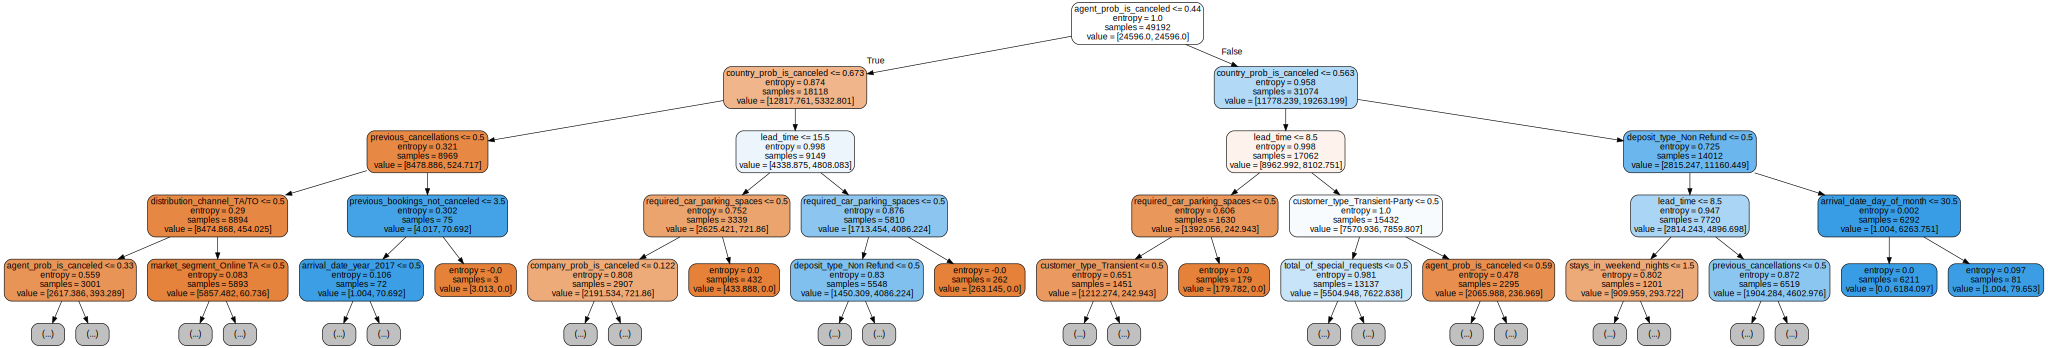

In [ ]:
dot_data = export_graphviz(best_model, out_file=None, feature_names=X.columns, filled=True, rounded=True, max_depth=4)
graphviz.Source(dot_data)

Analizamos los primeros 5 niveles. 

1) Se fija si agent_prob_is_canceled es <= 0.44, si es True va a izquierda y si es False va a la derecha.

2) Por derecha pregunta si country_prob_is_canceled <= 0.563, y por izquierda si country_prob_is_canceled <= 0.673.


3) Pregunta el lead_time, por el centro tiene 2 opciones por la izquierda si es <= a 15.5 y por derecha si es <= 8.5. Luego por la izquierda de todo pregunta si previous_cancellations <= 0.5. Por derecha de todo se fija si es deposit_type_Non Refund.

4) Observando de izquierda a derecha, se fija si agent_prob_is_canceled <= 0.33, luego si es market_segment_Online TA, luego si arrival_date es 2017, a continuación aparece el primer nodo hoja de nuestro arbol, luego si compan_prob_is_canceled <= 0.122, después aparece otro nodo hoja, ahora deposit_type es Non Refound, otro nodo hoja, luego si customer_type es Transient, luego aparece otro nodo hoja, después total_os_special_requests es <= 0.5, ahora si agent_prob_is_canceled <= 0.59, después si stays_in_weekend_nights es <= 1.5, ahora previous_cancellations <= 0.5, luego aparecen otros dos nodos hoja.

Obtenemos la matriz de confusión.

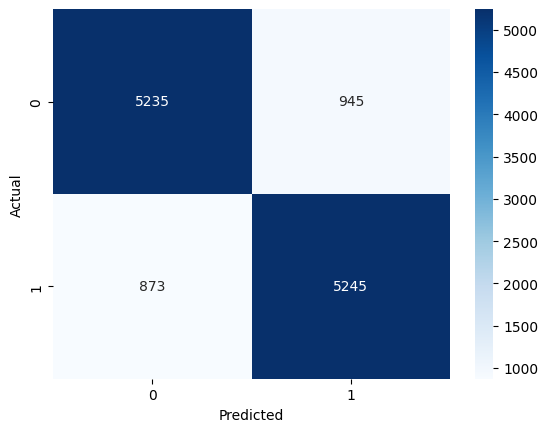

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Podemos ver que nustro modelo predice correctamente casi la misma cantidad de 0 y 1, pero tiene más falsos positivos que falsos negativos.

También podemos observar el árbol de otra forma, viendo unicamente las reglas utilizadas, aun que no es tan fácil de leer.

In [ ]:
from sklearn.tree import export_text
tree_rules = export_text(best_model, feature_names=list(X.columns))
print(tree_rules)

|--- agent_prob_is_canceled <= 0.44
|   |--- country_prob_is_canceled <= 0.67
|   |   |--- previous_cancellations <= 0.50
|   |   |   |--- distribution_channel_TA/TO <= 0.50
|   |   |   |   |--- agent_prob_is_canceled <= 0.33
|   |   |   |   |   |--- lead_time <= 15.50
|   |   |   |   |   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |   |   |   |   |--- customer_type_Transient <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- customer_type_Transient >  0.50
|   |   |   |   |   |   |   |   |--- arrival_date_day_of_month <= 22.50
|   |   |   |   |   |   |   |   |   |--- agent_prob_is_canceled <= 0.28
|   |   |   |   |   |   |   |   |   |   |--- booking_changes <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- booking_changes >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- agent_prob_is_canceled >  0.28


Ahora, guardamos el árbol obtenido en formato .pkl y lo cargamos.

In [200]:
import joblib
joblib.dump(best_model, 'modelo_arbol_decision_final.pkl')
loaded_model = joblib.load('modelo_arbol_decision_final.pkl')
predicciones = loaded_model.predict(df_hotel_test)

Por último guardamos el .csv que utilizamos para subirlo a la competencia de Kaggle.

In [201]:
df_sub = pd.DataFrame({'id': df_hotel_test_con_is_canceled['id'], 'is_canceled': predicciones})
df_sub.to_csv('prediccion_final.csv', index=False)